In [1]:
from rouge_score.rouge_scorer import _create_ngrams
from nltk.stem.porter import PorterStemmer
import json
from utils import tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import tqdm

PorterStemmer = PorterStemmer()
# nlp = spacy.load('en_core_web_sm')

In [23]:
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A = human_scores
    B = gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()
    # what is the TPR for FPR = 0.1?
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.01:
            
            print(f"TPR at 1% FPR: {tpr[idx]:.4f}")
            print(f"threshold at 1% FPR: {thresholds[idx]}")
            print(f"thresholds: {thresholds}")
            break
    return roc_auc, tpr[idx]

In [24]:
def get_score_ngrams(target_ngrams, prediction_ngrams):
    ngram_list = []
    intersection_ngrams_count = 0
    ngram_dict = {}
    for ngram in target_ngrams.keys(): # six.iterkeys(target_ngrams)
        num_of_intersections = min(target_ngrams[ngram], prediction_ngrams[ngram])
        intersection_ngrams_count += num_of_intersections
        ngram_dict[ngram] = num_of_intersections
        if num_of_intersections != 0 and (ngram not in ngram_list): ngram_list.append(ngram)
    target_ngrams_count = sum(target_ngrams.values()) # prediction_ngrams
    return intersection_ngrams_count / max(target_ngrams_count, 1), ngram_dict, ngram_list


def get_ngram_info(article_tokens, summary_tokens, _ngram):
    article_ngram = _create_ngrams( article_tokens , _ngram)
    summary_ngram = _create_ngrams( summary_tokens , _ngram)
    # print(article_ngram)
    ngram_score, ngram_dict, ngram_list = get_score_ngrams( article_ngram, summary_ngram) 
    # print(ngram_list)
    return ngram_score, ngram_dict, sum( ngram_dict.values() )

In [16]:
with open(os.path.join(os.getcwd(), '..', '..', 'data', 'essay_regen_gpt35_0.5_k10_nogold.json'), "r") as f:
    gpt35_list = json.load(f)['list']
print(len(gpt35_list))

128


In [17]:
########################## with questions ##########################
ngram_overlap_count_wq = []
for idx, result_dict in tqdm.tqdm(enumerate( gpt35_list ), total=len(gpt35_list)):
    human_07 = result_dict["human_gen_truncate"] # gold_gen_truncate, gold_gen_07
    gpt_07 = result_dict['machine_gen_truncate'] # gen_completion_truncate, gen_completion_07
    
    human_tokens = tokenize( human_07, stemmer=PorterStemmer)
    gpt_tokens = tokenize( gpt_07, stemmer=PorterStemmer)
    # print(gpt_tokens)
    ########################################
    human_half = result_dict['human_gen_text']
    gpt_half = result_dict['machine_gen_text']
    temp = []
    for i in range(len(human_half)): # len(human_half)
        temp1 = {}
        temp2 = {}
        human_generate_tokens = tokenize(human_half[i], stemmer=PorterStemmer)
        gpt_generate_tokens = tokenize(gpt_half[i], stemmer=PorterStemmer )
        if len(human_generate_tokens) == 0 or len(gpt_generate_tokens) == 0:
            continue
        for _ngram in range(1, 25): # 4, 25
            ngram_score, ngram_dict, overlap_count = get_ngram_info(human_tokens, human_generate_tokens, _ngram)
            temp1['human_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(human_generate_tokens)
            temp1['human_truncate_ngram_{}_count'.format(_ngram)] = overlap_count

            ngram_score, ngram_dict, overlap_count = get_ngram_info(gpt_tokens, gpt_generate_tokens, _ngram)
            temp2['gpt_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(gpt_generate_tokens)
            temp2['gpt_truncate_ngram_{}_count'.format(_ngram)] = overlap_count
        temp.append({'human':temp1, 'machine':temp2})

    ngram_overlap_count_wq.append(temp)

100%|██████████| 128/128 [00:56<00:00,  2.26it/s]


In [84]:
# print(json.dumps({'ugh': ngram_overlap_count_wq}, indent=4))

In [25]:
def N_gram_detector(ngram_n_ratio):
    score = 0
    non_zero = []
    
    for idx, key in enumerate(ngram_n_ratio):
        if idx in range(3) and 'score' in key or 'ratio' in key:
            score += 0. * ngram_n_ratio[ key ]
            continue
        if 'score' in key or 'ratio' in key:
            score += (idx+1) * np.log((idx+1))   * ngram_n_ratio[ key ]
            if ngram_n_ratio[ key ] != 0:
                non_zero.append( idx+1 )
    
    # print(non_zero)
    return score/ (sum( non_zero ) + 1e-8)

human_scores = []
gpt_scores = []

for result_dict in ngram_overlap_count_wq:
    human_score = []
    gpt_score = []

    for i in range(len(result_dict)):
        human_score.append( N_gram_detector(result_dict[i]['human'] ) )
        gpt_score.append( N_gram_detector(result_dict[i]['machine'] ) )

    human_scores.append( sum(human_score)   )
    gpt_scores.append( sum(gpt_score)   )
# print(result_dict[0])

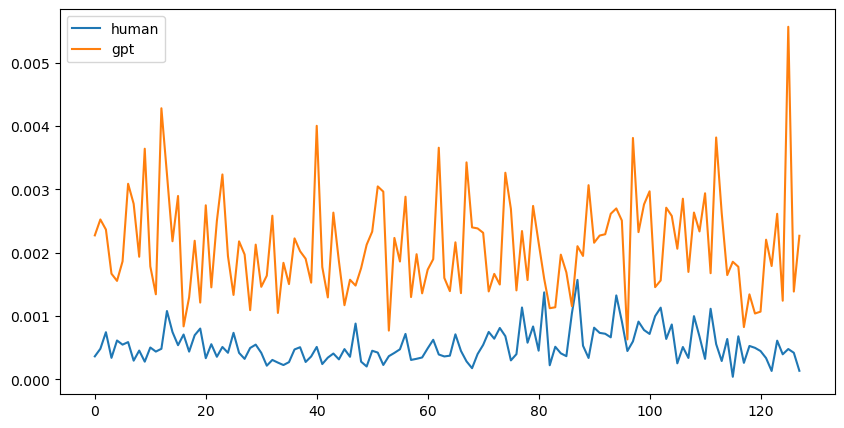

In [26]:
# plot and give different colors
import matplotlib.pyplot as plt
#human_scores, gpt_scores = human_scores[:40], gpt_scores[:40]
plt.figure(figsize=(10, 5))
plt.plot(human_scores, label='human')
plt.plot(gpt_scores, label='gpt')
plt.legend()
plt.show()

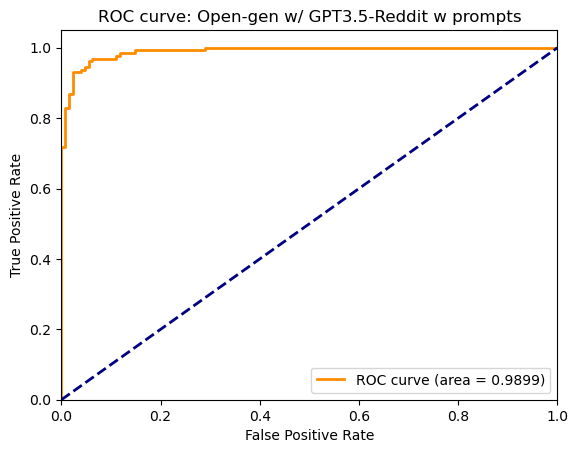

TPR at 1% FPR: 0.8281
threshold at 1% FPR: 0.001375161528379888
thresholds: [1.00556910e+00 5.56909963e-03 1.57433032e-03 1.57227934e-03
 1.38793217e-03 1.37516153e-03 1.33461781e-03 1.32732969e-03
 1.13978763e-03 1.13408786e-03 1.12507131e-03 1.11614485e-03
 1.09417800e-03 1.08073204e-03 1.05025975e-03 1.04666077e-03
 1.04130925e-03 8.67893114e-04 8.38278884e-04 8.36402819e-04
 8.27140685e-04 7.80270131e-04 7.71610986e-04 6.39179582e-04
 6.31999227e-04 4.21842254e-05]


(0.9898681640625, 0.828125)

In [27]:
plot_roc_curve( human_scores, gpt_scores )

In [13]:
###### openai detector ######
with open( f'results/openai_detect_gpt35.jsonl', 'r') as f:
    openai_detect_gpt = [json.loads(x) for x in f.read().strip().split("\n")]
len(openai_detect_gpt)

FileNotFoundError: [Errno 2] No such file or directory: 'results/openai_detect_gpt35.jsonl'

In [ ]:
# plot and give different colors
import matplotlib.pyplot as plt
human_scores2 = [x['gold_gen_prob'] for x in openai_detect_gpt]
gpt_scores2 = [x['gen_completion_prob'] for x in openai_detect_gpt]

plt.figure(figsize=(10, 5))
plt.plot(human_scores2, label='human')
plt.plot(gpt_scores2, label='gpt')
plt.legend()
plt.show()

In [ ]:
plot_roc_curve(human_scores2, gpt_scores2)

In [ ]:
###### gptzero detector ######
with open( f'results/detect_gptzero_200.jsonl', 'r') as f:
    gptzero_detect_gpt = [json.loads(x) for x in f.read().strip().split("\n")]
len(gptzero_detect_gpt)

In [ ]:
# plot and give different colors
import matplotlib.pyplot as plt
human_scores2 = [x['gold_gen_prob'] for x in gptzero_detect_gpt]
gpt_scores2 = [x['gen_completion_prob'] for x in gptzero_detect_gpt]

plt.figure(figsize=(10, 5))
plt.plot(human_scores2, label='human')
plt.plot(gpt_scores2, label='gpt')
plt.legend()
plt.show()

In [ ]:
plot_roc_curve(human_scores2, gpt_scores2)